In [2]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#read the file
df = pd.read_csv(r'C:\Users\Hp\Desktop\Sepsis100.csv')
#print the file
df


,index,HR,Temp,SBP,MAP,Resp,PaCO2,Creatinine,Bilirubin_direct,Bilirubin_total,WBC,Platelets,SepsisLabel
0,0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,97.0,0.0,98.0,75.33,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,89.0,0.0,122.0,86.00,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,90.0,0.0,0.0,0.00,30.0,100.0,0.0,0.0,0.0,0.0,0.0,0
4,4,103.0,0.0,122.0,91.33,24.5,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32412,32412,90.0,37.0,116.0,78.00,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32413,32413,89.0,0.0,96.0,69.00,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32414,32414,90.0,0.0,111.0,75.00,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32415,32415,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['index', 'SepsisLabel'])
for i in range(0,len(data)):
    new_data['index'][i] = data['index'][i]
    new_data['SepsisLabel'][i] = data['SepsisLabel'][i]

#setting index
new_data.index = new_data.index
new_data.drop('index', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:28000,:]
valid = dataset[28000:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Using TensorFlow backend.


In [4]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(x_train, y_train, epochs=2, batch_size=250,shuffle=True)

Epoch 1/2
27940/27940 [==============================] - 25s 885us/step - loss: 0.0036
Epoch 2/2
27940/27940 [==============================] - 26s 924us/step - loss: 0.0035


In [32]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
Sepsis_label = model.predict(X_test)
Sepsis_label = scaler.inverse_transform(Sepsis_label)

In [33]:
rms=np.sqrt(np.mean(np.power((valid-Sepsis_label),2)))
rms


SepsisLabel    0.057412
Predictions    0.002696
dtype: float64

E:\Chill\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


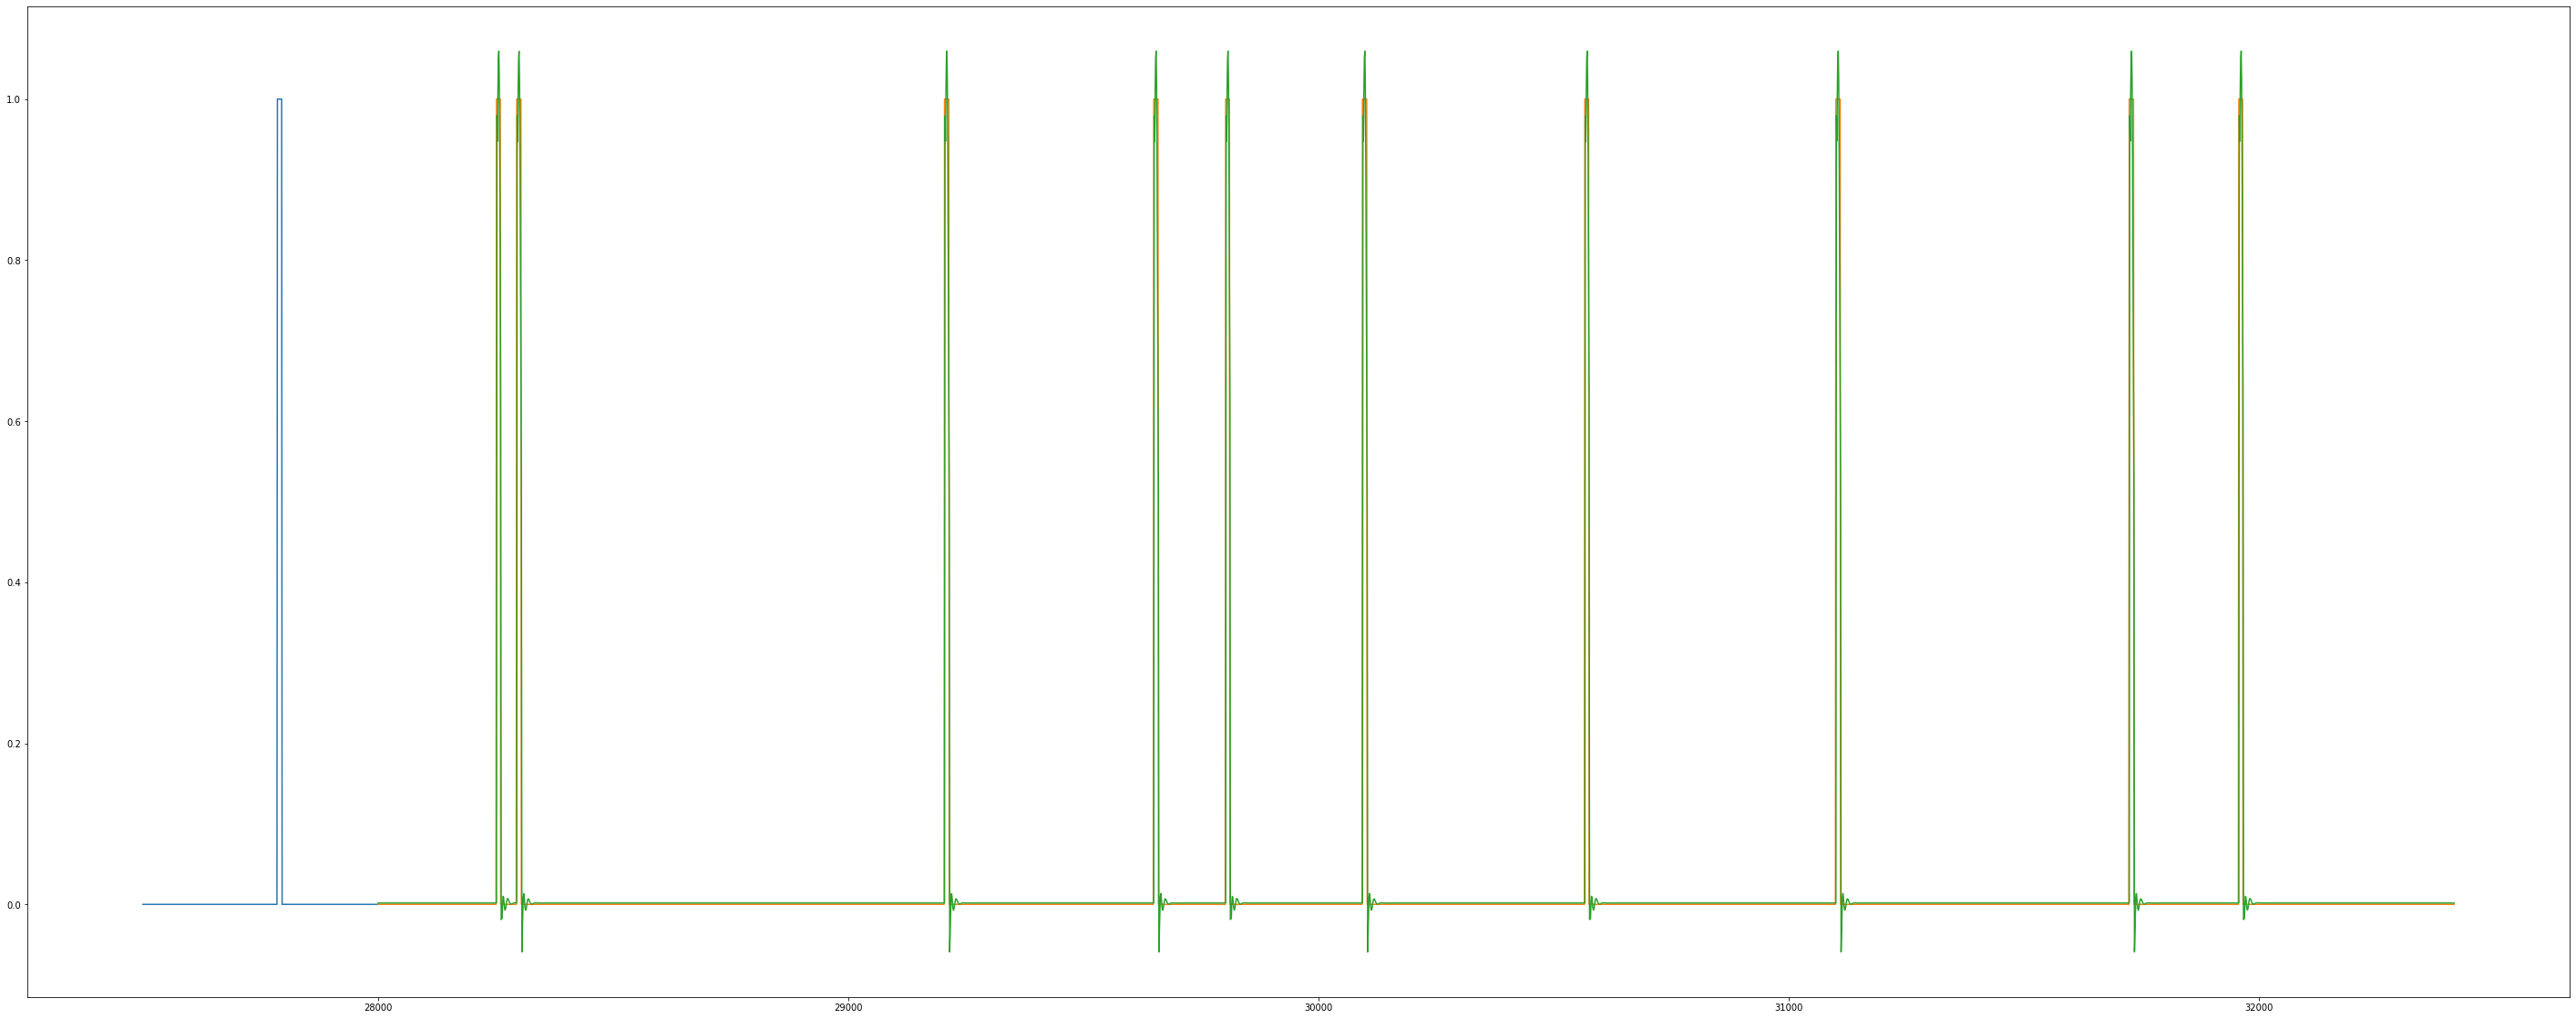

In [37]:
#for plotting
train = new_data[27500:28000]
valid = new_data[28000:]
valid['Predictions'] = Sepsis_label
plt.figure(figsize=(50,20))
plt.plot(train['SepsisLabel'])
plt.plot(valid[['SepsisLabel','Predictions']])

In [15]:
model.save('lstm_Sepsis.h5')

In [108]:
r = valid[['SepsisLabel','Predictions']]

In [109]:
r.to_csv(r'C:\Users\Hp\Desktop\Sepsispred.csv')